## Prediction stock prices
Adapted from:
https://www.kaggle.com/taronzakaryan/stock-prediction-lstm-using-pytorch

In [2]:
import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable
import os

cuda0 = torch.device('cuda:0')

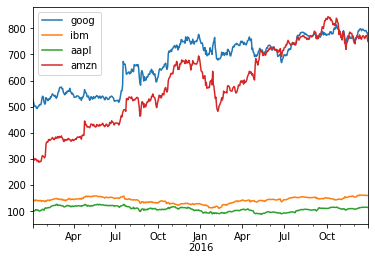

In [3]:
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv("dataset/Data/Stocks/{}.us.txt".format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

dates = pd.date_range('2015-01-02','2016-12-31',freq='B')
symbols = ['goog','ibm','aapl', 'amzn']
df = stocks_data(symbols, dates)
df.fillna(method='pad')
#print(df)
df.interpolate().plot()
plt.show()

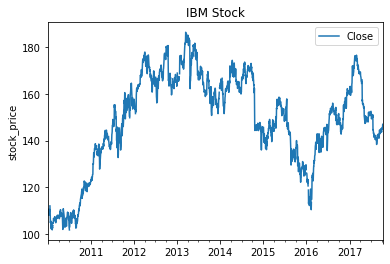

In [4]:
dates = pd.date_range('2010-01-02','2017-10-11',freq='B')
df1=pd.DataFrame(index=dates)
df_ibm=pd.read_csv("dataset/Data/Stocks/ibm.us.txt", parse_dates=True, index_col=0)
df_ibm=df1.join(df_ibm)
df_ibm[['Close']].plot()
plt.ylabel("stock_price")
plt.title("IBM Stock")
plt.show()

In [5]:
df_ibm=df_ibm[['Close']]
df_ibm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2028 entries, 2010-01-04 to 2017-10-11
Freq: B
Data columns (total 1 columns):
Close    1958 non-null float64
dtypes: float64(1)
memory usage: 111.7 KB


In [6]:
df_ibm=df_ibm.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
df_ibm['Close'] = scaler.fit_transform(df_ibm['Close'].values.reshape(-1,1))
#df_ibm

In [7]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 20 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_ibm, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

C:\Users\jetma\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


x_train.shape =  (1606, 19, 1)
y_train.shape =  (1606, 1)
x_test.shape =  (402, 19, 1)
y_test.shape =  (402, 1)


In [8]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

#train_X = train_X.view([-1, x_train.shape[0], 1])
#test_X = test_X.view([-1, x_test.shape[0], 1])
#train_Y = train_Y.view([y_train.shape[0], 1])

In [9]:
y_train.size(),x_train.size()

(torch.Size([1606, 1]), torch.Size([1606, 19, 1]))

In [10]:
n_steps = look_back-1
batch_size = 1606
#n_iters = 3000
num_epochs = 100 #n_iters / (len(train_X) / batch_size)
#num_epochs = int(num_epochs)

train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)

train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [11]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
torch.manual_seed(42)    

model1 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model2 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model3 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model4 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(size_average=True)

optimisers = {'SGD':torch.optim.SGD(model1.parameters(), lr=0.01),
              'Adam':torch.optim.Adam(model2.parameters(), lr=0.01),
              'Adagrad':torch.optim.Adagrad(model3.parameters(), lr=0.01),
              'RMSprop':torch.optim.RMSprop(model4.parameters(), lr=0.01)}

C:\Users\jetma\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [12]:
# Train model
#####################

hists = [np.zeros(num_epochs) for i in range(len(optimisers))]

# Number of steps to unroll
seq_dim =look_back-1

def train(model, i, optimiser, hists):
    for t in range(num_epochs):
        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        #model.hidden = model.init_hidden()

        # Forward pass
        y_train_pred = model(x_train)

        loss = loss_fn(y_train_pred, y_train)
        if t % 10 == 0 and t !=0:
            print("Epoch ", t, "MSE: ", loss.item())
        hists[i][t] = loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
    return y_train_pred

In [13]:
y_train_pred1 = train(model1, 0, optimisers['SGD'], hists)

Epoch  10 MSE:  0.2717268764972687
Epoch  20 MSE:  0.2697417438030243
Epoch  30 MSE:  0.26825299859046936
Epoch  40 MSE:  0.26704612374305725
Epoch  50 MSE:  0.26599833369255066
Epoch  60 MSE:  0.26503926515579224
Epoch  70 MSE:  0.26412832736968994
Epoch  80 MSE:  0.2632416784763336
Epoch  90 MSE:  0.2623652517795563


In [14]:
y_train_pred2 = train(model2, 1, optimisers['Adam'], hists)

Epoch  10 MSE:  0.03896358236670494
Epoch  20 MSE:  0.011862015351653099
Epoch  30 MSE:  0.010737122036516666
Epoch  40 MSE:  0.006933822296559811
Epoch  50 MSE:  0.0050964271649718285
Epoch  60 MSE:  0.004422138910740614
Epoch  70 MSE:  0.004062131512910128
Epoch  80 MSE:  0.0037706331349909306
Epoch  90 MSE:  0.00359406229108572


In [15]:
y_train_pred3 = train(model3, 2, optimisers['Adagrad'], hists)

Epoch  10 MSE:  0.01200713962316513
Epoch  20 MSE:  0.010465207509696484
Epoch  30 MSE:  0.009633476845920086
Epoch  40 MSE:  0.009034738875925541
Epoch  50 MSE:  0.008580010384321213
Epoch  60 MSE:  0.008223372511565685
Epoch  70 MSE:  0.007936234585940838
Epoch  80 MSE:  0.007699604146182537
Epoch  90 MSE:  0.007500330917537212


In [16]:
y_train_pred4 = train(model4, 3, optimisers['RMSprop'], hists)

Epoch  10 MSE:  0.2596198320388794
Epoch  20 MSE:  0.07684329897165298
Epoch  30 MSE:  0.012742560356855392
Epoch  40 MSE:  0.011083871126174927
Epoch  50 MSE:  0.006676728371530771
Epoch  60 MSE:  0.008803491480648518
Epoch  70 MSE:  0.007420585956424475
Epoch  80 MSE:  0.006743177305907011
Epoch  90 MSE:  0.010347246192395687


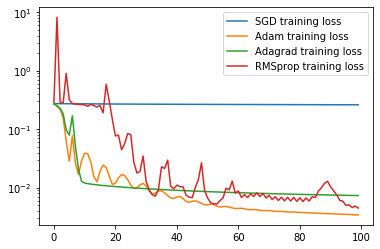

In [17]:
# plt.plot(y_train_pred.detach().numpy(), label="Preds")
# plt.plot(y_train.detach().numpy(), label="Data")
# plt.legend()
# plt.show()

plt.plot(hists[0], label="SGD training loss")
plt.plot(hists[1], label="Adam training loss")
plt.plot(hists[2], label="Adagrad training loss")
plt.plot(hists[3], label="RMSprop training loss")
plt.legend()
plt.yscale('log')
plt.show()

### Analysis


In [18]:
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

#### SGD

In [19]:
# make predictions
y_test_pred1 = model1(x_test)

# invert predictions
y_train_pred1 = scaler.inverse_transform(y_train_pred1.detach().numpy())
y_test_pred1 = scaler.inverse_transform(y_test_pred1.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred1[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred1[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 21.64 RMSE
Test Score: 10.69 RMSE


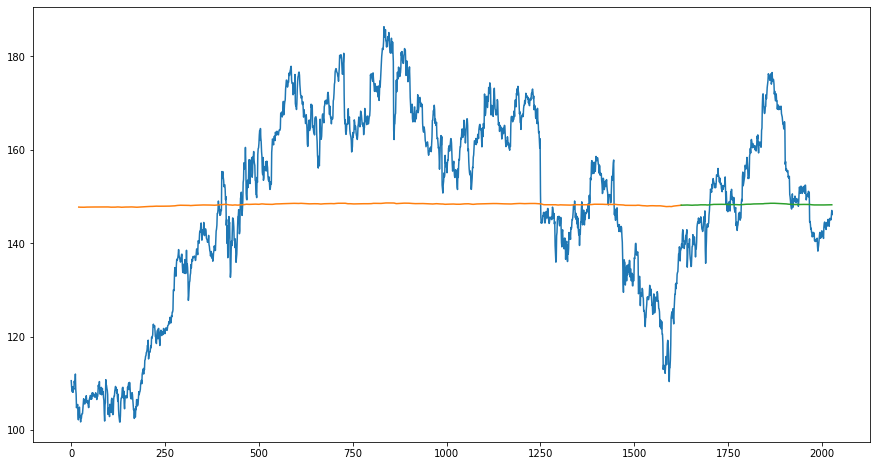

In [23]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_ibm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred1)+look_back, :] = y_train_pred1

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_ibm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred1)+look_back-1:len(df_ibm)-1, :] = y_test_pred1

# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(df_ibm))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

#### Adam

In [20]:
# make predictions
y_test_pred2 = model2(x_test)

# invert predictions
y_train_pred2 = scaler.inverse_transform(y_train_pred2.detach().numpy())
y_test_pred2 = scaler.inverse_transform(y_test_pred2.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred2[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred2[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.48 RMSE
Test Score: 1.92 RMSE


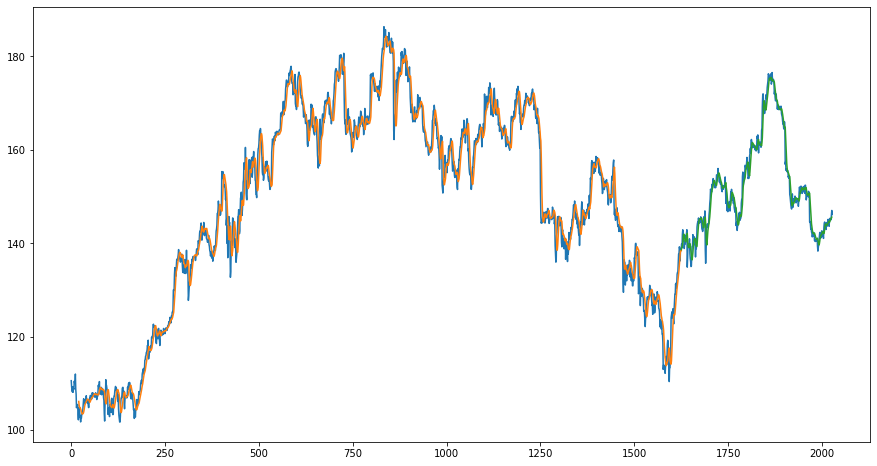

In [24]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_ibm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred1)+look_back, :] = y_train_pred2

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_ibm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred1)+look_back-1:len(df_ibm)-1, :] = y_test_pred2

# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(df_ibm))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

#### Adagrad

In [21]:
# make predictions
y_test_pred3 = model3(x_test)

# invert predictions
y_train_pred3 = scaler.inverse_transform(y_train_pred3.detach().numpy())
y_test_pred3 = scaler.inverse_transform(y_test_pred3.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred3[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred3[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.63 RMSE
Test Score: 2.95 RMSE


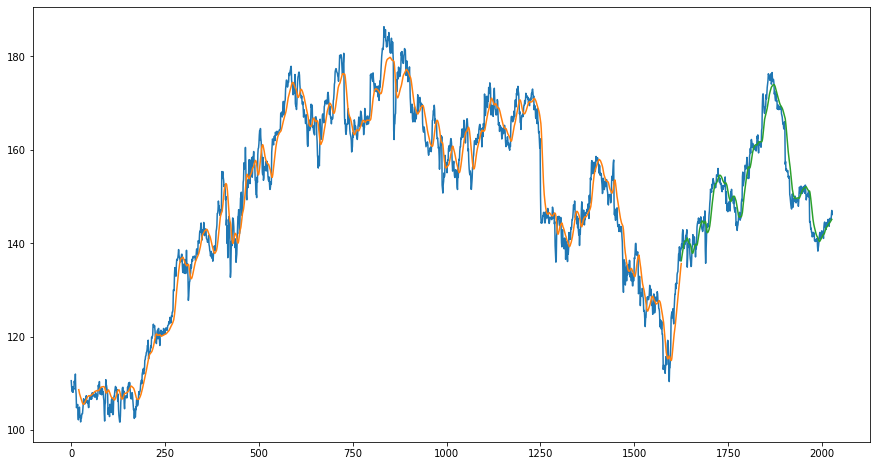

In [25]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_ibm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred1)+look_back, :] = y_train_pred3

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_ibm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred1)+look_back-1:len(df_ibm)-1, :] = y_test_pred3

# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(df_ibm))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

#### RMSprop

In [22]:
# make predictions
y_test_pred4 = model4(x_test)

# invert predictions
y_train_pred4 = scaler.inverse_transform(y_train_pred4.detach().numpy())
y_test_pred4 = scaler.inverse_transform(y_test_pred4.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred4[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred4[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.84 RMSE
Test Score: 2.40 RMSE


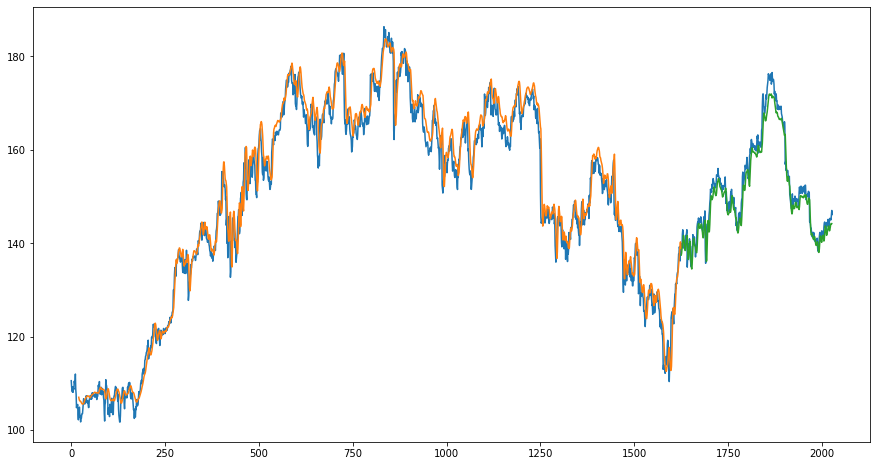

In [26]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_ibm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred1)+look_back, :] = y_train_pred4

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_ibm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred1)+look_back-1:len(df_ibm)-1, :] = y_test_pred4

# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(df_ibm))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()